In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Import data and pre-processing:

In [ ]:
# import
import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Embedding, Input, LSTM, Bidirectional, GlobalAveragePooling1D
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report

import tensorflow_addons as tfa
from tcn import TCN, tcn_full_summary


C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Conv1D, BatchNormalization, Input, Reshape, Conv1DTranspose, MaxPooling1D, UpSampling1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import plot_model

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9568392528091112688
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22712156160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6221838867661734761
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6"
]


# Importing single beat dataset

In [ ]:
# from google.colab import drive

# drive.mount('/gdrive')

In [ ]:
#path = "/gdrive/My Drive/Full Dataset/train test val split"
path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\data compilation\train test val split"
train = pd.read_csv(os.path.join(path, 'train_soft_segments.csv'), index_col=[0,1,2,3]).sort_index()
val = pd.read_csv(os.path.join(path, 'val_soft_segments.csv'), index_col=[0,1,2,3]).sort_index()
test = pd.read_csv(os.path.join(path, 'test_soft_segments.csv'), index_col=[0,1,2,3]).sort_index()

In [ ]:
train.reset_index().drug.unique()

array(['ctrl', 'quinidine', 'propranolol', 'verapamil', 'E4031'],
      dtype=object)

In [ ]:
data_train = train.loc[:,"0":]
data_val = val.loc[:,"0":]
data_test = test.loc[:,"0":]
class_train = train["class"]
class_val = val["class"]
class_test = test["class"]

In [ ]:
drug_test = test['drug']
drug_val = val['drug']
drug_train = train['drug']

In [ ]:
drug_test.append(drug_val).append(drug_train).value_counts()

C:\Users\YBLab\AppData\Local\Temp\ipykernel_26452\2169053732.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  drug_test.append(drug_val).append(drug_train).value_counts()
C:\Users\YBLab\AppData\Local\Temp\ipykernel_26452\2169053732.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  drug_test.append(drug_val).append(drug_train).value_counts()


ctrl           20769
quinidine      12428
E4031          12383
verapamil      11696
propranolol    10759
Name: drug, dtype: int64

In [ ]:
# old data processing
le = preprocessing.LabelEncoder()
le.fit(np.array(class_test).flatten())

print("combine data classes: ",le.classes_)

label_test = le.transform(class_test)
label_train = le.transform(class_train)
label_val = le.transform(class_val)


combine data classes:  ['I' 'II' 'III' 'IV' 'ctrl']


In [ ]:
from tensorflow.keras.utils import to_categorical

# old data
# y_ohe_old = to_categorical(y_old, num_classes=len(np.unique(y_old)))

y_test = to_categorical(label_test, num_classes=len(np.unique(label_test)))
y_train = to_categorical(label_train, num_classes=len(np.unique(label_train)))
y_val = to_categorical(label_val, num_classes=len(np.unique(label_val)))


In [ ]:
np.sum(y_train, axis=0)

array([ 8670.,  7671.,  8657.,  8267., 14416.], dtype=float32)

In [ ]:
def reshape_x(data):
  return np.array(data).reshape(data.shape[0], data.shape[1], 1)

X_train = reshape_x(data_train)
X_test = reshape_x(data_test)
X_val = reshape_x(data_val)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(47681, 200, 1) (10335, 200, 1) (10019, 200, 1)
(47681, 5) (10335, 5) (10019, 5)


## Example data:

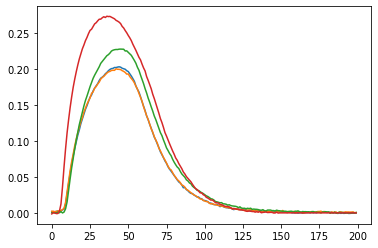

In [ ]:
plt.plot(X_train[10])
plt.plot(X_train[20])
plt.plot(X_train[30])
plt.plot(X_train[100])

## Importing the summary datasets

In [ ]:
#path = "/gdrive/My Drive/Full Dataset/train test val split"
train_summary = pd.read_csv(os.path.join(path, 'train_soft_summary.csv'), index_col=[0,1,2])
val_summary = pd.read_csv(os.path.join(path, 'val_soft_summary.csv'), index_col=[0,1,2])
test_summary = pd.read_csv(os.path.join(path, 'test_soft_summary.csv'), index_col=[0,1,2])

In [ ]:
train_summary['drug'].append(val_summary['drug']).append(test_summary['drug']).value_counts()

C:\Users\YBLab\AppData\Local\Temp\ipykernel_26452\1282496772.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_summary['drug'].append(val_summary['drug']).append(test_summary['drug']).value_counts()
C:\Users\YBLab\AppData\Local\Temp\ipykernel_26452\1282496772.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_summary['drug'].append(val_summary['drug']).append(test_summary['drug']).value_counts()


ctrl           544
quinidine      376
propranolol    326
E4031          319
verapamil      243
Name: drug, dtype: int64

# Define assessment metrics and set up evaluating & saving model

In [ ]:
def beat2sample_pred(y_true, y_pred, index):
    # y_true should have shape (# of beats, # of class)
    # y_pred should have shape (# of beats, # of class)
    # index should be a pd.MultiIndex with 3 levels in order: 'plate','row','col' with length # of beats


    # we need to make y_pred's elements only consist of 0 and 1 where argmax is 1 and rest are 0
    new_y_pred = np.zeros(y_pred.shape)
    new_y_pred[range(y_pred.shape[0]), np.argmax(y_pred,axis=1)] = 1

    # y_pred at the sample level where each beat is weighted equally
    y_pred_sample = pd.DataFrame(new_y_pred, index = index).groupby(['plate','row','col']).mean().sort_index()

    # format y_true so that it is at the sample level
    y_true_sample = pd.DataFrame(y_true, index = index).reset_index().drop('beat',axis=1).drop_duplicates().set_index(['plate','row','col']).sort_index()
    return y_true_sample, y_pred_sample, y_true_sample.index

def beat_accuracy(y_true, y_pred, index=None):
    ### parameters
    # y_true should have shape (# of beats, # of class)
    # y_pred should have shape (# of beats, # of class)
    correct_count = (np.argmax(np.array(y_true), axis=1) == np.argmax(np.array(y_pred),axis=1)).sum()
    all_count = len(y_true)
    return correct_count / all_count

def sample_accuracy(y_true, y_pred, index):
    y_true_sample, y_pred_sample, _ = beat2sample_pred(y_true, y_pred, index)

    # then call the same function as above to assess
    return beat_accuracy(y_true_sample.to_numpy(), y_pred_sample.to_numpy())

# Evaluation function
def evaluate_model(history,X_test,y_test,index,model, export=False):

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']


    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    y_pred=np.argmax(prediction_proba,axis=1)
    print("Beat accuracy: %.2f%%" % beat_accuracy(y_test, prediction_proba))
    cfn_matrix = confusion_matrix(y_true, y_pred)
    xticklabels = le.classes_
    yticklabels = le.classes_
    sns.heatmap(cfn_matrix, annot = True, xticklabels = xticklabels, yticklabels=yticklabels)
    plt.title("Beat level confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=le.classes_))



    y_true_sample, y_pred_sample, index_sample = beat2sample_pred(y_test, prediction_proba, data_test.index)
    cfn_matrix_sample = confusion_matrix(np.argmax(y_true_sample.to_numpy(), axis=1), np.argmax(y_pred_sample.to_numpy(), axis=1))
    print("Sample accuracy: %.2f%%" % beat_accuracy(y_true_sample, y_pred_sample))
    sns.heatmap(cfn_matrix_sample, annot = True, xticklabels = xticklabels, yticklabels=yticklabels)
    plt.title("Sample level confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    print(classification_report(np.argmax(y_true_sample.to_numpy(), axis=1), np.argmax(y_pred_sample.to_numpy(), axis=1), target_names=le.classes_))

    if export:
        os.makedirs(export, exist_ok=True)
        cfn_matrix_frame = pd.DataFrame(cfn_matrix, index="True "+le.classes_, columns="Pred "+le.classes_).to_csv(os.path.join(export, "beat_confusion_matrix.csv"))
        cfn_matrix_sample_frame = pd.DataFrame(cfn_matrix_sample, index="True "+le.classes_, columns="Pred "+le.classes_).to_csv(os.path.join(export, "sample_confusion_matrix.csv"))
        pd.DataFrame(classification_report(np.argmax(y_true_sample.to_numpy(), axis=1), np.argmax(y_pred_sample.to_numpy(), axis=1), target_names=le.classes_, output_dict=True)).T.to_csv(os.path.join(export, "sample_clsf_summary.csv"))
        pd.DataFrame(classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)).T.to_csv(os.path.join(export, "beat_clsf_summary.csv"))
        wrong_index = pd.DataFrame()
        wrong_index['true'] = class_test
        wrong_index['pred'] = le.inverse_transform(np.argmax(np.array(prediction_proba),axis=1))
        wrong_index['correct'] = (np.argmax(np.array(y_test), axis=1) == np.argmax(np.array(prediction_proba),axis=1))
        wrong_index.to_csv(os.path.join(export, "misclassified.csv"))
        model.save(os.path.join(export, "model.h5"))




In [ ]:
class_test

plate         row  col  beat
2021.08.19    A    2    0       ctrl
                        1       ctrl
                        2       ctrl
                        3       ctrl
                        4       ctrl
                                ... 
2022.09.20_A  G    11   10         I
                        11         I
                        12         I
                        13         I
                        14         I
Name: class, Length: 10019, dtype: object

In [ ]:
class_weight = 1 / (y_train.mean(axis=0) * y_train.shape[1])
class_weight_dict = dict(enumerate(class_weight))

# Bidirectional LSTM

In [ ]:
def network_LSTM():
    im_shape=(X_train.shape[1],X_train.shape[2])
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    # Your code
    #dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
    dense = inputs_lstm
    lstm = (layers.Bidirectional(layers.LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(dense))
    lstm = Dropout(0.2)(lstm)
    lstm=BatchNormalization()(lstm)

    lstm = layers.Bidirectional(layers.LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(lstm)
    lstm = Dropout(0.2)(lstm)
    lstm=BatchNormalization()(lstm)

    # drop = Dropout(0.4)

    flatten=Flatten()(lstm)
    # dense_end1 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(flatten)
    # drop_1 = Dropout(0.2)(dense_end1)
    # batch_normalization_1=BatchNormalization()(drop_1)
    dense_end2 = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(flatten)
    drop_2 = Dropout(0.2)(dense_end2)
    batch_normalization_2=BatchNormalization()(drop_2)
    dense_end3 = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(batch_normalization_2)
    drop_3 = Dropout(0.2)(dense_end3)
    batch_normalization_3=BatchNormalization()(drop_3)
    main_output = Dense(y_train.shape[1], activation='softmax', name='main_output')(batch_normalization_3)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics = ['accuracy'])

    return(model)

# TCN-LSTM

In [ ]:
def create_tcn_old():
    i = Input(shape=(X_train.shape[1], X_train.shape[2]))
    m = TCN(nb_filters=128,
                     kernel_size=2,
                     nb_stacks=4,
                     dilations=(1, 2, 4, 8),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.1,
                     activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                     kernel_initializer='he_normal',
                     use_batch_norm=True,
                     use_layer_norm=False,
                     use_weight_norm=False,
                     return_sequences = True)(i)

    m = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(m)
    m = Dropout(0.2)(m)
    m = BatchNormalization()(m)
    m = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(m)
    m = Dropout(0.2)(m)
    m = BatchNormalization()(m)

    m = Flatten()(m)
    #m = TimeDistributed(Dense(output_dim, activation = 'linear'))(m)
    m = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(m)
    m = Dropout(0.2)(m)
    m=BatchNormalization()(m)
    m = Dense(y_train.shape[1], activation='softmax')(m)

    model = Model(inputs=[i], outputs=[m])

    model.summary()

    return model

In [ ]:
def create_tcn():
    i = Input(shape=(X_train.shape[1], X_train.shape[2]))
    m = TCN(nb_filters=128,
                     kernel_size=2,
                     nb_stacks=4,
                     dilations=(1, 2, 4, 8),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.1,
                     activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                     kernel_initializer='he_normal',
                     use_batch_norm=True,
                     use_layer_norm=False,
                     use_weight_norm=False,
                     return_sequences = True)(i)

    m = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(m)
    m = Dropout(0.2)(m)
    m = BatchNormalization()(m)
    # m = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(l=0.001)))(m)
    # m = Dropout(0.2)(m)
    # m = BatchNormalization()(m)

    m = Flatten()(m)
    #m = TimeDistributed(Dense(output_dim, activation = 'linear'))(m)
    m = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(m)
    m = Dropout(0.2)(m)
    m=BatchNormalization()(m)
    m = Dense(y_train.shape[1], activation='softmax')(m)

    model = Model(inputs=[i], outputs=[m])

    model.summary()

    return model

# TCN only

In [ ]:
def create_tcn_only():
    i = Input(shape=(X_train.shape[1], X_train.shape[2]))
    m = TCN(nb_filters=128,
                     kernel_size=2,
                     nb_stacks=4,
                     dilations=(1, 2, 4, 8),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.1,
                     activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                     kernel_initializer='he_normal',
                     use_batch_norm=True,
                     use_layer_norm=False,
                     use_weight_norm=False,
                     return_sequences = True)(i)

    m = Flatten()(m)
    m = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))(m)
    m = Dropout(0.2)(m)
    m = BatchNormalization()(m)
    m = Dense(y_train.shape[1], activation='softmax')(m)

    model = Model(inputs=[i], outputs=[m])

    model.summary()

    return model

# CNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Dropout, MaxPool1D, Flatten

def create_encoder():
    encoder = Sequential()

    encoder.add(Conv1D(filters=128, kernel_size = 10, padding='same', kernel_initializer='he_normal', activation='relu', input_shape=(X_val.shape[1],X_val.shape[2])))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.2))
    encoder.add(Conv1D(filters=128, kernel_size= 8, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.2))
    encoder.add(Conv1D(filters=64, kernel_size= 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.2))
    encoder.add(Conv1D(filters=32, kernel_size= 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
    encoder.add(BatchNormalization())
    encoder.add(MaxPool1D(pool_size=4))
    encoder.add(Dropout(0.2))
    encoder.add(Flatten())
    return encoder

def create_classifier(encoder, trainable=True):
    classifier = Sequential()
    for layer in encoder.layers:
        layer.trainable = trainable
        classifier.add(layer)

    classifier.add(Dense(units=64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), activation='relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units=32, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), activation='relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units=y_train.shape[1], activation='softmax'))
    return classifier


# MLSTM-FCN

In [ ]:
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout


def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = input.shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se



def generate_model():
    ip = Input(shape=(scaled_X_val.shape[1],scaled_X_val.shape[2]))

    x = Masking()(ip)
    x = LSTM(128)(x)
    x = Dropout(0.2)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

# Train, evaluate, and save model

In [ ]:
#for model_name in ["biLSTM", "TCN-LSTM", "TCN", "CNN", "MLSTM-FCN"]:
    for iteration in range(1,6):
        export_name = "time_series\\" + model_name + "_" + str(iteration)
        print(export_name)
        if model_name == "biLSTM":
            model = network_LSTM()
        elif model_name == "TCN-LSTM":
            model = create_tcn()
        elif model_name == "TCN":
            model = create_tcn_only()
        elif model_name == "CNN":
            model = create_classifier(create_encoder())
        elif model_name == "MLSTM-FCN":
            model = generate_mlstm_fcn()
        elif model_name == "RNN":
            model = network_RNN()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=2, min_lr=1e-10)
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(X_train, y_train,epochs=100, shuffle = True, batch_size=32,validation_data=(X_val,y_val), callbacks = [es, reduce_lr], class_weight=class_weight_dict)
        evaluate_model(history,X_test,y_test,data_test.index, model, export=export_name)
